In [1]:
!nvidia-smi

Sat Apr 27 06:54:50 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    18W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!ls drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'   data


# Change Directory

In [3]:
import os
!ls drive
print(os.getcwd())
os.chdir("drive/My Drive/data/fcn_pytorch") # to project dir
print(os.getcwd())
!ls

'My Drive'
/content
/content/drive/My Drive/data/unet_pytorch
checkpoint.tar	log


# Import

In [0]:
import os
import re
import time
import copy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import torch.optim as optim

# Setting Directory

In [0]:
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

train_data_dir = "../datasets/voc_semseg/train"
val_data_dir = "../datasets/voc_semseg/val"

train_img_dir = os.path.join(train_data_dir, 'img')
train_gt_dir = os.path.join(train_data_dir, 'gt')
val_img_dir = os.path.join(val_data_dir, 'img')
val_gt_dir = os.path.join(val_data_dir, 'gt')

# Utility Functions

In [0]:
def key_sort_by_num(x):
    re_list = re.findall(r"[0-9]+", x)
    re_list = list(map(int, re_list))
    return re_list


def list_from_dir(dir, target_ext=None):
    img_list = []
    fnames = os.listdir(dir)
    fnames = sorted(fnames, key=key_sort_by_num)
    for fname in fnames:
        if target_ext is None:
            path = os.path.join(dir, fname)
            img_list.append(path)
        else:
            _, ext = os.path.splitext(fname)
            if ext.lower() in target_ext:
                path = os.path.join(dir, fname)
                img_list.append(path)
    return img_list

In [0]:
#train_data_paths = list_from_dir(train_img_dir, ('.jpg', '.png'))
#train_gt_paths = list_from_dir(train_gt_dir, ('.jpg', '.png'))
#val_data_paths = list_from_dir(val_img_dir, ('.jpg', '.png'))
#val_gt_paths = list_from_dir(val_gt_dir, ('.jpg', '.png'))

#print(len(train_data_paths))
#print(len(train_gt_paths))
#print(len(val_data_paths))
#print(len(val_gt_paths))

In [0]:
def make_cmap():
    ctbl = ((0x80, 0, 0), (0, 0x80, 0), (0, 0, 0x80),
            (0x40, 0, 0), (0, 0x40, 0), (0, 0, 0x40),
            (0x20, 0, 0), (0, 0x20, 0))

    n = 256
    lookup = np.zeros((n, 3)).astype(np.int32)
    for i in range(0, n):
        r, g, b = 0, 0, 0
        for j in range(0, 7):
            bit = (i >> j) & 1
            if bit:
                r |= ctbl[j][0]
                g |= ctbl[j][1]
                b |= ctbl[j][2]

        lookup[i, 0], lookup[i, 1], lookup[i, 2] = r, g, b
    return lookup[0:21]

In [0]:
def pil_to_tensor(pil_img):
    """ Convert from PIL to tensor
     # Arguments
            pil_img: array, 3 dimention(H x W x C)
    """
    img = np.array(pil_img, copy=False)
    img = img.transpose((2, 0, 1)) # H x W x C -> C x H x W
    img = img.astype(np.float32) # uint8 -> float32
    img = torch.from_numpy(img) # ndarray -> tensor
    img.div_(255)
    return img


def tensor_to_pil(tesnor_img):
    """ Convert from Tensor to PIL
     # Arguments
            tesnor_img: tensor, 3 dimention(C x H x W )
    """
    img = tesnor_img.mul(255).numpy() # tensor -> ndarray
    img = np.array(img, dtype=np.uint8) # float32 -> uint8
    img = img.transpose(1,2,0) # C x H x W -> H x W x C
    return Image.fromarray(img)


def tensor_to_ndarray(tesnor_img):
    """ Convert from Tensor to ndarray
     # Arguments
            tesnor_img: tensor, 3 dimention(C x H x W )
    """
    img = tesnor_img.mul(255).numpy() # tensor -> ndarray
    img = np.array(img, dtype=np.uint8) # float32 -> uint8
    img = img.transpose(1,2,0) # C x H x W -> H x W x C
    return img



def pil_to_one_hot_array(label_array, classes, size):
    """ Convert from PIL to one-hot-array
     # Arguments
            label_array: array, 3 dimention(H x W x C)
            classes: int, num of class
            size: int, image shape
    """
    x = np.zeros((classes, size, size)) # C x H x W
    for i in range(size):
        for j in range(size):
            x[label_array[i][j], i, j] = 1
    return x


def pred_to_pil(pred):
    """ Convert from one-hot-array to PIL
     # Arguments
            pred: tensor, 3 dimention(C x H x W)
    """
    cmap = make_cmap()
    
    pred_ = pred.numpy() # tensor -> ndarray
    channel, _, _ = pred_.shape
    pred_ = pred_.transpose(1, 2, 0) # C x H x W -> H x W x C
    pred_ = np.argmax(pred_, axis=2) #  H x W x C -> H x W
    
    row, col = pred_.shape
    dst = np.ones((row, col, 3))
    
    for i in range(channel):
        dst[pred_ == i] = cmap[i]

    dst = dst.astype(np.uint8)
    return  Image.fromarray(dst) # ndarray -> PIL

In [0]:
def show_imgs(imgs, size,  figsize=[6.4, 4.8], converter=False):
    """Show images
     # Arguments
            imgs: 1-D array, 4 dimention(batch x H x W x C)
            row: Int, row for plt.subplot
            col: Int, column for plt.subplot
    """
    row, col = size
    if len(imgs) != (row * col):
        raise ValueError("Invalid imgs len:{} col:{} row:{}".format(len(imgs), row, col))

  
    plt.figure(figsize=figsize)
    plt.tight_layout()

    for i, img in enumerate(imgs):
        if converter:
            img = converter(img)
        plot_num = i+1
        plt.subplot(row, col, plot_num)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Create Dataset and DataLoader

In [0]:
class SemSegDataset(Dataset):
    
    def __init__(self, classes, input_size, img_dir, target_dir=None, train=False):
        self.classes = classes
        self.input_size = input_size
        
        self.img_paths = list_from_dir(img_dir, ('.jpg', '.png'))
        if target_dir:
            self.target_paths = list_from_dir(target_dir, ('.jpg', '.png'))
        else:
            self.        if target_dir:
            target_num = len(self.target_paths)
            assert img_num == target_num, "img/gt not equal, img:{} gt:{}".format(img_num, target_num) = None
            
        self.train = train
        
        self.eval_trns = transforms.Compose([
            transforms.CenterCrop(self.input_size)
        ])

        # check data num
        img_num = len(self.img_paths)
        if target_dir:
            target_num = len(self.target_paths)
            assert img_num == target_num, "img/gt not equal, img:{} gt:{}".format(img_num, target_num)
        
        self.data_num = img_num

        
    def __len__(self):
        return self.data_num
    
    
    def _transform(self, img, target, train):
        
        if train:
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=self.input_size)
            img = TF.crop(img, i, j, h, w)
            if target:
                target = TF.crop(target, i, j, h, w)
      
            if random.random() < 0.5:
                image = TF.hflip(image)
                if target:
                    target = TF.hflip(target)
            
        else:
            img = self.eval_trns(img)
            if target:
                target = self.eval_trns(target)
     
        img = pil_to_tensor(img) # 0-255 -> 0-1
        
        if target:
            target = np.asarray(target, dtype=np.int32)
            target[target == 255] = 0  # 境界部分をbackgroundクラスにする
            target = pil_to_one_hot_array(target, self.classes, self.input_size)
            target = torch.from_numpy(target).long() # ラベルをtensor型に変換
        
        return img, target

    def __getitem__(self, idx):
        assert idx < self.data_num,"invalid idx {}, max idx is {}".format(idx, self.data_num-1)
        
        img = Image.open(self.img_paths[idx])
        if self.target_paths:
            target = Image.open(self.target_paths[idx])
        else:
            target = None
        
        x, y = self._transform(img, target, self.train)

        return x, y

In [0]:
train_dataset = SemSegDataset(21, 224, train_img_dir, train_gt_dir)
val_dataset    = SemSegDataset(21, 224, val_img_dir, val_gt_dir)

In [0]:
x,y = train_dataset[0]

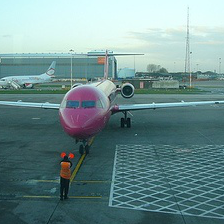

In [15]:
tensor_to_pil(x)

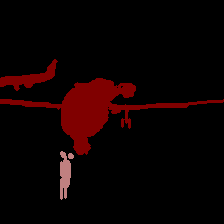

In [16]:
pred_to_pil(y)

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=4)
val_dataloader    = DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=4)

torch.Size([24, 3, 224, 224])
torch.Size([24, 21, 224, 224])


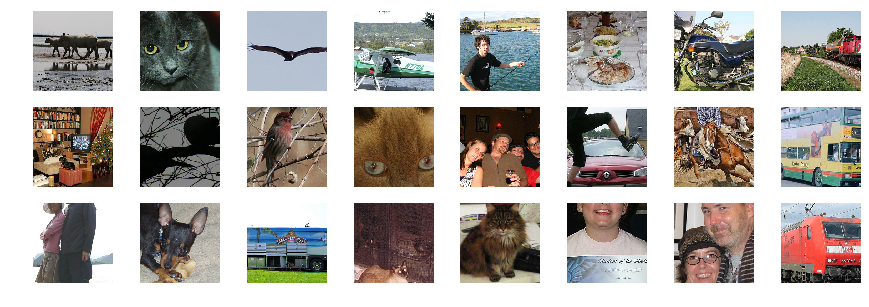

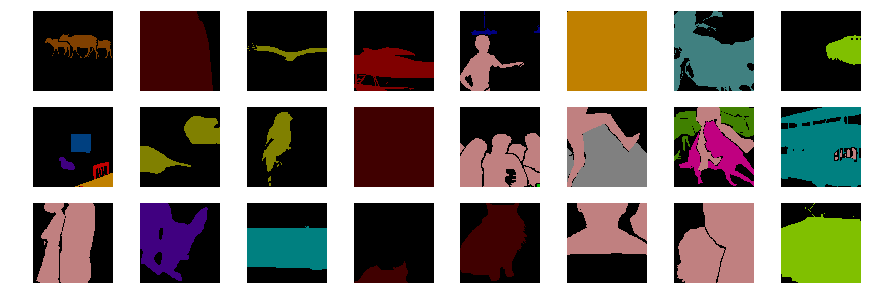

In [18]:
for d in train_dataloader:
    print(d[0].shape)
    print(d[1].shape)
    break
    
            
show_imgs(d[0], [3, 8], figsize=(15,5), converter=tensor_to_ndarray)
show_imgs(d[1], [3, 8], figsize=(15,5), converter=pred_to_pil)

# Define Model

In [0]:
# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/models/fcn32s.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """
    Make a 2D bilinear kernel suitable for upsampling
    """
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
             (1 - abs(og[1] - center) / factor)
    
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt

    return torch.from_numpy(weight).float()

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock

class EncorderResNet(ResNet):
    
    def __init__(self, layers=[2, 2, 2, 2]):
        super().__init__(BasicBlock, layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x3 = x
        x = self.layer3(x)
        x4 = x
        x = self.layer4(x)
        x5 = x
        
        return x3, x4, x5

In [0]:
class FCN32s(nn.Module):
    
    def __init__(self, num_classes, encorder):
        super().__init__()
        
        self.encorder = encorder
        
        self.relu = nn.ReLU(inplace=True)
        
        self.score5 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=64, stride=32, padding=16,
                                                                       bias=False)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init_w = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(init_w)
                
    def forward(self, x):
        
        x3, x4, x5 = self.encorder(x)
               
        x = self.score5(x5)
        
        x = self.upscore(x)
        
        return x

In [0]:
class FCN16s(nn.Module):
    
    def __init__(self, num_classes, encorder):
        super().__init__()
        
        self.encorder = encorder
           
        self.score4 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score5 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        self.upscore4 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=4, stride=2, padding=1,
                                                                       bias=False)
        self.upscore5 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=8, stride=4, padding=2,
                                                                       bias=False)
 
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=16, stride=8, padding=4,
                                                                       bias=False)

        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init_w = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(init_w)
    
    
    def forward(self, x):
        
        x3, x4, x5 = self.encorder(x)
                
        x4 = self.score4(x4)
        x5 = self.score5(x5)
        
        x4 = self.upscore4(x4)
        x5 = self.upscore5(x5)
        
        x = x4 + x5
        
        x = self.upscore(x)
        
        return x

In [0]:
class FCN8s(nn.Module):
    
    def __init__(self, num_classes, encorder):
        super().__init__()
        
        self.encorder = encorder
           
        self.score3 = nn.Conv2d(128, num_classes, kernel_size=1)
        self.score4 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score5 = nn.Conv2d(512, num_classes, kernel_size=1)

        self.upscore4 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=4, stride=2, padding=1,
                                                                       bias=False)
        self.upscore5 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=8, stride=4, padding=2,
                                                                       bias=False)
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=16, stride=8, padding=4,
                                                                       bias=False)

        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init_w = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(init_w)
        
    def forward(self, x):
        
        x3, x4, x5 = self.encorder(x)
                
        x3 = self.score3(x3)
        x4 = self.score4(x4)
        x5 = self.score5(x5)
        
        x4 = self.upscore4(x4)
        x5 = self.upscore5(x5)
        
        x = x3 + x4 + x5
        
        x = self.upscore(x)
        
        return x

# Create Model

In [0]:
from torchvision.models import resnet18

encorder = EncorderResNet(layers=[2, 2, 2, 2])
encorder.load_state_dict(resnet18(pretrained=True).state_dict())
model = FCN8s(num_classes=21, encorder=encorder)

In [25]:
from torchsummary import summary
summary(model,  input_size=(3, 224, 224),   device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Define Trainer

In [26]:
# pip install tqdm
pip install fastprogress

In [0]:
# from tqdm import tqdm_notebook as tqdm
from fastprogress import master_bar, progress_bar
import copy
import time


def calc_acc(preds, labels):
    correct = (preds == labels).sum()
    total     = (labels == labels).sum()
    correct = correct.to(torch.float32)
    total     = total.to(torch.float32)
    return (correct / total)


class Trainer:
    
    def __init__(self, model, device, optimizer, criterion, train_loader, val_loader=None,
                          scheduler=None, history=None, prev_epochs=0):

        self.print_state = True
        
        self.done_epochs = prev_epochs # 0-
        
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        
        self.scheduler = scheduler
        
        self.best_val_acc = 0.0
        self.best_model_wts = copy.deepcopy(model.state_dict())
        
        if history:
            self.history = history
        else:
            self.history = {'epoch':[], 'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}
        
        self.train_loader = train_loader
        self.train_data_num = len(self.train_loader.dataset)
        self.train_sptes_per_epoch = len(self.train_loader)
        
        self.val_loader = val_loader
        if self.val_loader:
            self.val_data_num = len(self.val_loader.dataset)
            self.val_sptes_per_epoch = len(self.val_loader)
        else:
            self.val_data_num = 0
            self.val_sptes_per_epoch = 0

        self.model.to(self.device)
        
        
    def set_print_state(self, state=True):
        self.print_state = state
        
        
    def train_loop(self, epochs):
        total_epochs = self.done_epochs + epochs

        #------------------------------------------------------------------------
        # pre print
        #------------------------------------------------------------------------        
        if self.print_state:
            print("Device :  ", self.device)
            print("Train on {} samples, validate on {} samples".format(self.train_data_num,
                                                                                                                 self.val_data_num))
            for i in range(self.done_epochs):
                done_history_idx = i
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))

        #------------------------------------------------------------------------
        # training loop
        #------------------------------------------------------------------------
        for _ in range(epochs):
            self.history['epoch'].append(self.done_epochs+1) # 1-
            
            start_time = time.time()            
            train_score = self._train_one_epoch()
            end_time = time.time()
            
            self.history['train_acc'].append(train_score['acc'])
            self.history['train_loss'].append(train_score['loss'])
            
            if self.val_loader:
                val_score = self._val_one_epoch()
                self.history['val_acc'].append(val_score['acc'])
                self.history['val_loss'].append(val_score['loss'])
                
                if self.best_val_acc < val_score['acc']:
                    self.best_val_acc = val_score['acc']
                    self.best_model_wts = copy.deepcopy(model.state_dict())
                
                if self.scheduler:
                    self.scheduler.step(val_score['loss'])
                    
            else:
                if self.scheduler:
                    self.scheduler.step(train_score['loss'])
                

            self.done_epochs += 1

            #------------------------------------------------------------------------
            # post print
            #------------------------------------------------------------------------
            if self.print_state:
                elapsed_time = end_time-start_time
                done_history_idx = self.done_epochs-1
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))

                    
    def _one_step(self, data, labels, train=True):
            if train:
                self.optimizer.zero_grad()
            
            outputs = self.model(data)
            
            # (batchsize x C x H x W) -> (bachsize x H x W)
            labels = torch.argmax(labels, dim=1, keepdim=False)
            preds = torch.argmax(outputs, dim=1, keepdim=False)
            
            loss = self.criterion(outputs, labels)
            
            if train:
                loss.backward()
                self.optimizer.step()
            
            correct = calc_acc(preds, labels)

            return loss.item(), correct.item()

        
    def _train_one_epoch(self):
        self.model.train()
        
        running_loss = 0
        running_correct = 0

        #for batch_idx, (data, labels) in enumerate(self.train_loader):
        #for batch_idx, (data, labels) in tqdm(enumerate(self.train_loader)):
        for batch_idx, (data, labels) in enumerate(progress_bar(self.train_loader)): # naka
            data, labels = data.to(self.device), labels.to(self.device)
            
            loss, correct = self._one_step(data, labels, train=True)
    
            running_loss       += loss
            running_correct += correct

        train_loss = running_loss      / self.train_sptes_per_epoch
        train_acc = running_correct / self.train_sptes_per_epoch
        
        return {'loss':train_loss, 'acc':train_acc}

    
    def _val_one_epoch(self):
        self.model.eval()
        
        running_loss = 0
        running_correct = 0

        with torch.no_grad():
            for data, labels in self.val_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                
                loss, correct = self._one_step(data, labels, train=False)

                running_loss       += loss
                running_correct += correct
                
        val_loss = running_loss      / self.val_sptes_per_epoch
        val_acc = running_correct / self.val_sptes_per_epoch

        return {'loss':val_loss, 'acc':val_acc}

    
    def save_best_model(self, path):
        torch.save(self.best_model_wts, path)
    

    def save_checkpoint(self, path):
        ckpt = {
            'model_satate_dict':self.model.state_dict(),
            'optimizer_state_dict':self.optimizer.state_dict(),
            'history':self.history
        }
        torch.save(ckpt, path)

# Start Training

In [0]:
criterion = nn.CrossEntropyLoss() # nn.LogSoftmax() + nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [0]:
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1,
                                                                                            patience=6,  verbose=True) 

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
trainer = Trainer(model, device, optimizer, criterion, train_dataloader, val_dataloader,scheduler=exp_lr_scheduler)

cuda:0


In [31]:
trainer.train_loop(30)

Device :   cuda:0
Train on 1464 samples, validate on 1449 samples


Epoch:1/30 train_acc:0.6727% train_loss:1.2371 val_acc:0.7328% val_loss:0.8622 time:56.791


Epoch:2/30 train_acc:0.8082% train_loss:0.6017 val_acc:0.7472% val_loss:0.8200 time:55.414


Epoch:3/30 train_acc:0.8567% train_loss:0.4377 val_acc:0.7782% val_loss:0.7195 time:56.758


Epoch:4/30 train_acc:0.8927% train_loss:0.3222 val_acc:0.7879% val_loss:0.7022 time:56.550


Epoch:5/30 train_acc:0.9095% train_loss:0.2644 val_acc:0.7901% val_loss:0.6969 time:55.415


Epoch:6/30 train_acc:0.9179% train_loss:0.2346 val_acc:0.7985% val_loss:0.6669 time:59.084


Epoch:7/30 train_acc:0.9248% train_loss:0.2136 val_acc:0.7987% val_loss:0.6895 time:58.520


Epoch:8/30 train_acc:0.9291% train_loss:0.1984 val_acc:0.7979% val_loss:0.7037 time:58.960


Epoch:9/30 train_acc:0.9334% train_loss:0.1851 val_acc:0.7973% val_loss:0.7228 time:58.945


Epoch:10/30 train_acc:0.9373% train_loss:0.1731 val_acc:0.7991% val_loss:0.7171 time:57.882


Epoch:11/30 train_acc:0.9368% train_loss:0.1735 val_acc:0.8018% val_loss:0.7070 time:59.385


Epoch:12/30 train_acc:0.9400% train_loss:0.1630 val_acc:0.8010% val_loss:0.7158 time:57.313


Epoch    12: reducing learning rate of group 0 to 1.0000e-03.
Epoch:13/30 train_acc:0.9399% train_loss:0.1633 val_acc:0.7967% val_loss:0.7547 time:57.658


Epoch:14/30 train_acc:0.9440% train_loss:0.1510 val_acc:0.8018% val_loss:0.7273 time:57.738


Epoch:15/30 train_acc:0.9455% train_loss:0.1471 val_acc:0.8021% val_loss:0.7192 time:56.466


Epoch:16/30 train_acc:0.9459% train_loss:0.1451 val_acc:0.8023% val_loss:0.7163 time:58.574


Epoch:17/30 train_acc:0.9471% train_loss:0.1427 val_acc:0.8032% val_loss:0.7162 time:57.430


Epoch:18/30 train_acc:0.9475% train_loss:0.1420 val_acc:0.8025% val_loss:0.7160 time:57.212


Epoch:19/30 train_acc:0.9476% train_loss:0.1412 val_acc:0.8027% val_loss:0.7231 time:57.594


Epoch    19: reducing learning rate of group 0 to 1.0000e-04.
Epoch:20/30 train_acc:0.9481% train_loss:0.1394 val_acc:0.8034% val_loss:0.7251 time:58.101


Epoch:21/30 train_acc:0.9486% train_loss:0.1382 val_acc:0.8029% val_loss:0.7216 time:56.764


Epoch:22/30 train_acc:0.9486% train_loss:0.1387 val_acc:0.8014% val_loss:0.7362 time:54.924


Epoch:23/30 train_acc:0.9483% train_loss:0.1389 val_acc:0.8029% val_loss:0.7278 time:56.253


Epoch:24/30 train_acc:0.9491% train_loss:0.1372 val_acc:0.8037% val_loss:0.7173 time:56.220


Epoch:25/30 train_acc:0.9482% train_loss:0.1394 val_acc:0.8031% val_loss:0.7242 time:54.804


Epoch:26/30 train_acc:0.9485% train_loss:0.1386 val_acc:0.8029% val_loss:0.7221 time:56.403


Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
Epoch:27/30 train_acc:0.9478% train_loss:0.1407 val_acc:0.8027% val_loss:0.7137 time:57.021


Epoch:28/30 train_acc:0.9490% train_loss:0.1373 val_acc:0.8029% val_loss:0.7259 time:56.364


Epoch:29/30 train_acc:0.9485% train_loss:0.1384 val_acc:0.8032% val_loss:0.7219 time:56.829


Epoch:30/30 train_acc:0.9481% train_loss:0.1391 val_acc:0.8035% val_loss:0.7249 time:56.508


In [0]:
trainer.save_checkpoint('checkpoint_fcn8s.tar')
trainer.save_best_model('fcn8s.pt')

# Plot acc and loss curve

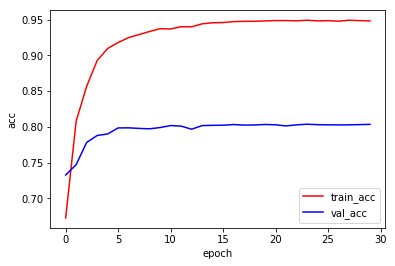

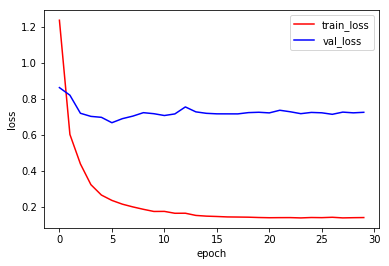

In [34]:
def plot_history(history):
    
    epochs = len(history['train_acc'],)
    
    xaxis = range(epochs)
    plt.figure()
    plt.plot(xaxis, history['train_acc'], 'r-', label='train_acc')
    plt.plot(xaxis, history['val_acc'], 'b-', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')


    plt.figure()
    plt.plot(xaxis, history['train_loss'], 'r-', label='train_loss')
    plt.plot(xaxis, history['val_loss'], 'b-', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

    
plot_history(trainer.history)

# Evaluate

In [0]:
 classnames=[
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boad",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "dining table",
    "dog",
    "horse",
    "motor_bike",
    "person",
    "potted_plant",
    "sheep",
    "sofa",
    "train",
    "tv"]

In [0]:
def evaluate(model, device, criterion, test_loader):
    model.eval()
    runnning_loss = 0
    running_correct = 0
    with torch.no_grad():
        for data in progress_bar(test_loader):
            imgs, labels = data            
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            
            labels = torch.argmax(labels, dim=1, keepdim=False)
            pred = torch.argmax(outputs, dim=1, keepdim=False)
            runnning_loss += criterion(outputs, labels).item()
            running_correct += calc_acc(pred, labels)
            
    test_acc = running_correct / len(test_loader)
    test_loss = runnning_loss / len(test_loader)

    return {'loss':test_loss, 'acc':test_acc}

In [42]:
test_loader = val_dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

model = model.to(device)
test_score = evaluate(model, device, criterion, test_loader)

device: cuda


In [43]:
print('acc  : {:.4f}'.format(test_score['acc']))
print('loss : {:.4f}'.format(test_score['loss']) )

acc  : 0.8035
loss : 0.7249


# Predict

In [0]:
def predict(model, device, imgs):
    model.eval()
    
    if len(imgs.size()) != 4:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device)
    
    with torch.no_grad():
        output = model(imgs)
        
    return output

In [0]:
device = 'cpu'
img, label = val_dataset[98]
model.to(device)
out = predict(model, device, img)

In [0]:
label_pil = pred_to_pil(label)
out_pil = pred_to_pil(out[0])
input_pil = tensor_to_pil(img)

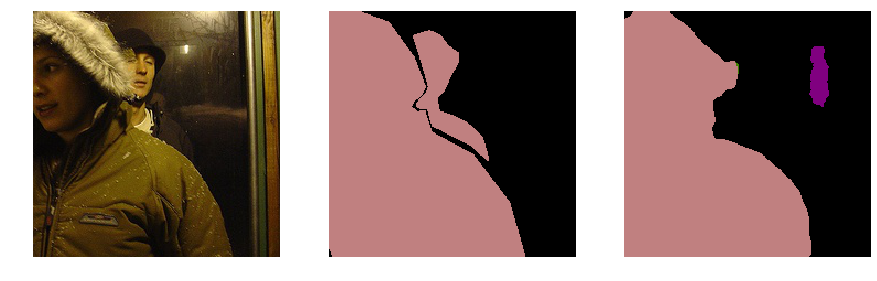

In [50]:
show_imgs([input_pil, label_pil, out_pil], [1, 3], figsize=(15,5))